In [1]:
import configuration

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import dataset_dataloader

In [2]:
from torchvision import transforms as T
import random
from PIL import Image
import torch
import os


from configuration import *
from  dataset_dataloader import *
from cross_modal_cvae_model import *

## Create Model

In [3]:
a=torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
b=a.sample((1,8,1,1))
xx=b.squeeze(4).to(DEVICE)

In [4]:
CM_gen = CrossModal(lambda_p, lambda_s, xx)
CM_gen = CM_gen.to(DEVICE)
CM_gen_optimizer = torch.optim.Adam(CM_gen.parameters(), learning_rate)

In [ ]:
## load pretrained model

In [5]:
checkpoint = torch.load("model_params_ACVAE20.tar")
CM_gen.load_state_dict(checkpoint['model_state_dict'])
CM_gen_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [6]:
## data loader to pick some random voice for given demography

In [7]:
FO = np.load("voice_cp_FO.npy", allow_pickle = True)
FY = np.load("voice_cp_FY.npy", allow_pickle = True)
MO = np.load("voice_cp_MO.npy", allow_pickle = True)
MY = np.load("voice_cp_MY.npy", allow_pickle = True)

'''
FO = torch.tensor(FO).to(DEVICE)
FY = torch.tensor(FY).to(DEVICE)
MO = torch.tensor(MO).to(DEVICE)
MY = torch.tensor(MY).to(DEVICE)
'''

def data_load_new(batchsize, s ):
    x = []
    label = []
    label_num = s
    
    if len(s) < batchsize:
        batch_iter_size = len(s)
    else:
        batch_iter_size = batchsize
    
    for i in range(batch_iter_size):
        
        if s[i][0]==0 and s[i][1] == 0:
            label_num = 0
            source = FO
            
        if s[i][0]==0 and s[i][1] == 1:
            label_num = 1
            source = FY
            
        if s[i][0]==1 and s[i][1] == 0:
            label_num = 2
            source = MO

        if s[i][0]==1 and s[i][1] == 1:
            label_num = 3
            source = MY
        
        index = random.randint(0,9)
        
        out = source[index, :, :, :]
        x.append(out)
        
        label.append(label_num)
        
    return torch.tensor(x), torch.tensor(label)

## Pick a random voice clip
## in this case 1,0 represents male, young to generate
## once this voice clip is passed into the molde it generates male yound pic

torch.Size([1, 2])


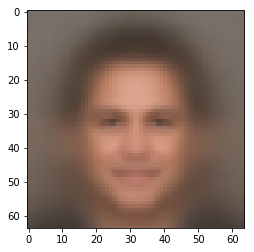

In [8]:
s1 = torch.tensor([[1,0]])
print(s1.size())
x, y = data_load_new(batchsize=1, s=s1)

ve_mu, ve_var = CM_gen.Voice_Encoder(x.to(DEVICE))


reparam_VE = CM_gen.reparameterize(ve_mu, ve_var)

recon_image_mu, recon_image_var = CM_gen.Face_Decoder(reparam_VE, xx)
#print(recon_image_mu)
recon_image = CM_gen.reparameterize(recon_image_mu, recon_image_var)
#print(recon_image)

recon1 = recon_image.view(3,64,64)

recon1 = recon1.transpose(0,2)

recon1 = recon1.transpose(0,1)

y11 = recon1.to('cpu')
plt.imshow(y11.detach().numpy())

## convert voice

In [11]:
##female young to male young

voice_path_s = './data/vcc2018/VCC2SF1/'
file='10001.wav'
voice_path_t = './data/vcc2018/VCC2SM1/'

output_voice_path= '/home/ubuntu/project2/voice_cvae/converted_voices/'

source_dir = 'VCC2SF1'
target_dir =  'VCC2SM1'

In [12]:
face_path_s = '/home/ubuntu/project2/CELEBA_DATA/MY_test/'
face_path_t = '/home/ubuntu/project2/CELEBA_DATA/FY_test/'
face_file_s =  '004087.jpg'
face_file_t=   '006996.jpg'

In [14]:
mode = 'test'
batch_size = 4
num_workers=1
crop_size=178
image_size=64

transform = []
if mode == 'train':
    transform.append(T.RandomHorizontalFlip())
transform.append(T.CenterCrop(crop_size))
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
#transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

image_target = Image.open(os.path.join(face_path_t, face_file_t))

image_source = Image.open(os.path.join(face_path_s, face_file_s )) 

face_target = transform(image_target)

face_target = face_target.unsqueeze(0)


face_source = transform(image_source)

face_source = face_source.unsqueeze(0)

In [15]:
wav, _ = librosa.load(os.path.join(voice_path_s, file), sr = sampling_rate, mono = True)
wav = librosa.util.normalize(wav, norm=np.inf, axis=None)
wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)


mc_transposed  = np.array(mc).T

mcep_normalization_params_s = np.load(os.path.join(voice_path_s, "mcep_"+source_dir+".npz"))
mcep_mean_s = mcep_normalization_params_s['mean']
mcep_std_s = mcep_normalization_params_s['std']    
mcep_normalization_params_t = np.load(os.path.join(voice_path_t, "mcep_"+target_dir+".npz"))
mcep_mean_t = mcep_normalization_params_t['mean']
mcep_std_t = mcep_normalization_params_t['std']

mc_norm = (mc_transposed - mcep_mean_s) / mcep_std_s

x = torch.Tensor(mc_norm).view(1, 1, mc_norm.shape[0], mc_norm.shape[1])

n_frames=1024
frames = np.shape(mc_transposed)[1]
# #print(frames)
start_ = np.random.randint(frames - n_frames + 1)
end_ = start_ + n_frames
x=x[:,:,:,start_:end_]


x = x.to(DEVICE)
face_target= face_target.to(DEVICE)

face_source = face_source.to(DEVICE)



#(face,_) in data_iter

CM_gen.eval()

UE_mu, UE_var = CM_gen.Utterance_Encoder(x)
FE_mu, FE_var = CM_gen.Face_Encoder(face_target)
reparam_UE = CM_gen.reparameterize(UE_mu, UE_var)
reparam_FE = CM_gen.reparameterize(FE_mu, FE_var)
UD_mu, UD_var = CM_gen.Utterance_Decoder(reparam_UE,reparam_FE)
recon_voice = CM_gen.reparameterize(UD_mu, UD_var)


FE_mu_s, FE_var_s = CM_gen.Face_Encoder(face_source)
reparam_FE_s = CM_gen.reparameterize(FE_mu_s, FE_var_s)
UD_mu_s, UD_var_s = CM_gen.Utterance_Decoder(reparam_UE,reparam_FE_s)
recon_voice_s = CM_gen.reparameterize(UD_mu_s, UD_var_s)


if (torch.cuda.is_available()):
    z_dec_s = recon_voice_s.data.cpu().numpy().reshape((mc_norm.shape[0], n_frames))
else:
    z_dec_s = recon_voice_s.data.numpy().reshape((mc_norm.shape[0], n_frames))


if (torch.cuda.is_available()):
    z_dec_t = recon_voice.data.cpu().numpy().reshape((mc_norm.shape[0], n_frames))
else:
    z_dec_t = recon_voice.data.numpy().reshape((mc_norm.shape[0], n_frames))
    

    
mc_converted_t = z_dec_t * mcep_std_t + mcep_mean_t
mc_converted_t = mc_converted_t.T
mc_converted_t = np.ascontiguousarray(mc_converted_t)
sp_converted_t = world_decode_mc(mc = mc_converted_t, fs = sampling_rate)


mc_converted_s = z_dec_s * mcep_std_s + mcep_mean_s
mc_converted_s = mc_converted_s.T
mc_converted_s = np.ascontiguousarray(mc_converted_s)
sp_converted_s = world_decode_mc(mc = mc_converted_s, fs = sampling_rate)

sp = sp[:n_frames,:]

sp_gained = np.multiply(sp, np.divide(sp_converted_t, sp_converted_s))

logf0s_normalization_params_s = np.load(os.path.join(voice_path_s, "log_f0_"+source_dir+".npz"))
logf0s_mean_s = logf0s_normalization_params_s['mean']
logf0s_std_s = logf0s_normalization_params_s['std']


logf0s_normalization_params_t = np.load(os.path.join(voice_path_t, "log_f0_"+target_dir+".npz"))
logf0s_mean_t = logf0s_normalization_params_t['mean']
logf0s_std_t = logf0s_normalization_params_t['std']



ap=ap[:n_frames]



f0_converted = pitch_conversion(f0 = f0, mean_log_src = logf0s_mean_s, std_log_src = logf0s_std_s, mean_log_target = logf0s_mean_t, std_log_target = logf0s_std_t)

f0_converted = f0_converted[:n_frames]
wav_transformed = world_speech_synthesis(f0 = f0_converted, sp = sp_gained, ap = ap, fs = sampling_rate, frame_period = frame_period)
librosa.output.write_wav(os.path.join(output_voice_path, source_dir +"_to_"+target_dir+".wav"), wav_transformed, sampling_rate)


/home/ubuntu/project2/voice_cvae/final_project/preprocess.py:375: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)
